# 前処理 (人間行動認識 p.27~)
観測した生データに対して処理を行い，機械学習に適した形に変換する

### 一般的な手順
1. クレンジング
1. フィルタリング
1. セグメンテーション
1. 特徴量抽出
1. 特徴量選択・次元削減
1. 正規化・標準化

### 今回の手順
1. クレンジング
   - 欠損値の補完
1. 特徴量抽出
2. データ正規化・標準化


In [1]:
# 必要なライブラリのインポート
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
import json
import re

In [2]:
# データディレクトリの設定
DATA_DIR = Path("./data")

# 特徴量抽出時のウィンドウ幅
WINDOW_SIZE_SEC = 5

# 特徴量抽出時のウィンドウのステップ幅
WINDOW_STEP_SEC = 0.5

In [3]:
# ラベル一覧の取得
# indexをIDとして使用する．LightGBM はラベル名が数値の連番である必要があるため
df_labels = pd.read_csv(DATA_DIR / "labels.csv", names=["label", "description"])
print(df_labels)

    label description
0  others         その他
1    walk          歩く
2     sit          座る
3    stop       立ち止まる


In [4]:
# データ名の取得 (DATA_DIR内のフォルダ名をリストとして取得)
data_names = [f.name for f in DATA_DIR.iterdir() if f.is_dir()]
print(f"データ名: {data_names}")

データ名: ['tada-1', 'tada-6', 'tada-5', 'tada-2', 'tada-3', 'tada-4']


In [5]:
# データを読み取り，整える
data = {}

for name in data_names:
    # 加速度の読み込み
    df_acc = pd.read_csv(
        DATA_DIR / name / "Accelerometer.csv", names=["time", "x", "y", "z"], header=1
    )
    # 角速度の読み込み
    df_gyro = pd.read_csv(
        DATA_DIR / name / "Gyroscope.csv", names=["time", "x", "y", "z"], header=1
    )

    # ラベルの読み込み
    with open(DATA_DIR / name / "labeling.json") as f:
        content = json.load(f)
        tricks = content[0]["tricks"]

    sensing_start = min(tricks, key=lambda x: x["start"])["start"]
    sensing_end = max(tricks, key=lambda x: x["end"])["end"]

    # sensing_start ～ sensing_end のデータのみ抽出
    df_acc = df_acc[(df_acc["time"] >= sensing_start) & (df_acc["time"] <= sensing_end)]
    df_gyro = df_gyro[
        (df_gyro["time"] >= sensing_start) & (df_gyro["time"] <= sensing_end)
    ]

    # df_acc, df_gyroにラベルを追加
    others_id = df_labels[df_labels["label"] == "others"].index[0]
    df_acc["label"] = others_id  # 初期値は others に設定
    df_gyro["label"] = others_id  # 初期値は others に設定

    for trick in tricks:
        label = trick["labels"]
        start_time = trick["start"]
        end_time = trick["end"]
        # 今回は同時に複数動作は行わない前提のため、最初のラベルのみ使用
        label = trick["labels"][0]
        # ラベル名からラベルIDを取得
        label_id = df_labels[df_labels["label"] == label].index[0]

        # df_accにラベルを追加
        df_acc.loc[
            (df_acc["time"] >= start_time) & (df_acc["time"] <= end_time), "label"
        ] = label_id

        # df_gyroにラベルを追加
        df_gyro.loc[
            (df_gyro["time"] >= start_time) & (df_gyro["time"] <= end_time), "label"
        ] = label_id

    data[name] = {"acc": df_acc, "gyro": df_gyro}

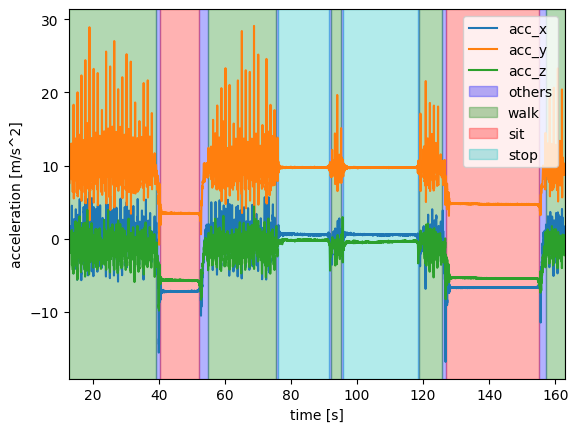

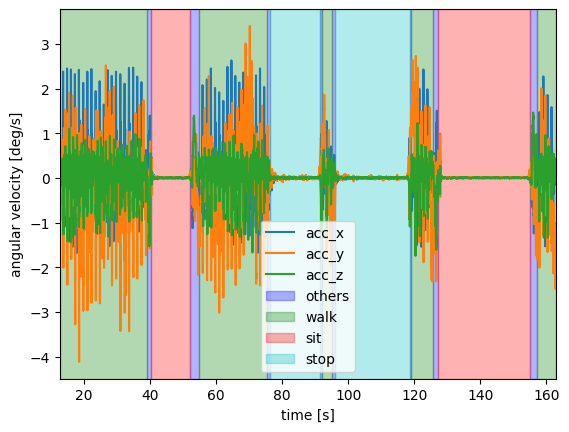

In [6]:
# 現状を確認 (加速度)
def plot(df, ylabel):
    plt.plot(df["time"], df["x"], label="acc_x")
    plt.plot(df["time"], df["y"], label="acc_y")
    plt.plot(df["time"], df["z"], label="acc_z")

    # 各グループに対して，開始時刻と終了時刻を取得し，背景色を変更
    colors = list(mcolors.BASE_COLORS.values())
    for i, s_label in df_labels.iterrows():
        color = colors[i % len(colors)]
        # df["label"] == i の背景色を変更
        mask = df["label"] == i
        times = df["time"]
        in_range = False
        label_name = s_label["label"]

        # 背景色を変更(連続する範囲ごとに処理)
        for idx, m in enumerate(mask):
            if m and not in_range:  # 範囲開始
                start_time = times.iloc[idx]
                in_range = True
            elif not m and in_range:  # 範囲終了
                end_time = times.iloc[idx - 1]
                plt.axvspan(
                    start_time, end_time, alpha=0.3, color=color, label=label_name
                )
                label_name = None  # 2回目以降はラベルを表示しない
                in_range = False

        if in_range:
            end_time = times.iloc[-1]
            plt.axvspan(start_time, end_time, alpha=0.3, color=color)

    # x軸の範囲を設定
    min_time = df["time"].min()
    max_time = df["time"].max()
    plt.xlim(min_time, max_time)

    plt.xlabel("time [s]")
    plt.ylabel(ylabel)
    plt.legend()
    plt.show()


df_acc = data[data_names[0]]["acc"]
df_gyro = data[data_names[0]]["gyro"]

plot(df_acc, "acceleration [m/s^2]")
plot(df_gyro, "angular velocity [deg/s]")

In [7]:
def extract_features(df, window_size, window_step, columns=["x", "y", "z", "norm"]):
    """
    ウィンドウ幅 window_size、ステップ幅 window_step で特徴量を抽出する関数
    比較的わかりやすいが，計算量が多くなるため遅い(numpyを使うと高速化できる)

    特徴量:
    - ラベル,
    - 各軸の最小値，最大値，平均，分散，標準偏差，中央値，各軸のゼロ交差率
    """
    features = pd.DataFrame()

    # ラベル, データ名, ユーザ名, 連番は最頻値を使用
    features["label"] = (
        df["label"].iloc[window_size - 1 :: window_step].reset_index(drop=True)
    )
    features["_data_name"] = (
        df["_data_name"].iloc[window_size - 1 :: window_step].reset_index(drop=True)
    )
    features["_user_name"] = (
        df["_user_name"].iloc[window_size - 1 :: window_step].reset_index(drop=True)
    )
    features["_number"] = (
        df["_number"].iloc[window_size - 1 :: window_step].reset_index(drop=True)
    )

    # 数値列の統計量
    stats = ["min", "max", "mean", "var", "std", "median"]
    for stat in stats:
        rolled = getattr(df[columns].rolling(window=window_size), stat)()
        # 列名を x_min, y_min, z_min のように変更して結合
        rolled = rolled.iloc[window_size - 1 :: window_step].reset_index(drop=True)
        rolled.columns = [f"{col}_{stat}" for col in rolled.columns]
        features = pd.concat([features, rolled], axis=1)

    # ゼロ交差率
    zcr = (
        df[columns]
        .rolling(window=window_size)
        .apply(lambda x: ((x[:-1] * x[1:]) < 0).sum())
        .iloc[window_size - 1 :: window_step]
        .reset_index(drop=True)
    )
    # 列名を x_zcr, y_zcr, z_zcr に変更
    zcr.columns = [f"{col}_zcr" for col in zcr.columns]
    features = pd.concat([features, zcr], axis=1)

    return features


def extract_features_fast(
    df, window_size, window_step, columns=["x", "y", "z", "norm"]
):
    """
    extract_features関数の高速版(らしい)
    TODO: 実装
    """
    raise NotImplementedError("未実装")

In [8]:
# データから特徴量を抽出し，保存
df_features = pd.DataFrame()

for name, dfs in data.items():
    df_acc = dfs["acc"]
    df_gyro = dfs["gyro"]

    # クレンジング(欠損値を線形補間で補完)
    df_acc = df_acc.interpolate()
    df_gyro = df_gyro.interpolate()

    # norm 列を追加
    df_acc["norm"] = np.sqrt(df_acc["x"] ** 2 + df_acc["y"] ** 2 + df_acc["z"] ** 2)
    df_gyro["norm"] = np.sqrt(df_gyro["x"] ** 2 + df_gyro["y"] ** 2 + df_gyro["z"] ** 2)

    df_merged = pd.merge_asof(
        df_acc.sort_values("time"),
        df_gyro.sort_values("time"),
        on="time",
        by="label",
        tolerance=0.01,  # 許容誤差
        direction="nearest",
        suffixes=("_acc", "_gyro"),
    )

    m = re.match(r"^(?P<name>.+)-(?P<number>\d+)$", name)
    if m:
        user_name = m.group("name")
        number = int(m.group("number"))
    else:
        user_name = "unknown"
        number = -1

    df_merged["_data_name"] = name
    df_merged["_user_name"] = user_name
    df_merged["_number"] = number

    # サンプリング周波数の計算
    fs = 1 / (
        (df_merged["time"].iloc[-1] - df_merged["time"].iloc[0]) / (len(df_merged) - 1)
    )

    # サンプル数のウィンドウ幅とステップ幅
    window_size = int(WINDOW_SIZE_SEC * fs)
    window_step = int(WINDOW_STEP_SEC * fs)

    # 特徴量を抽出
    df_features = pd.concat(
        [
            df_features,
            extract_features(
                df_merged,
                window_size,
                window_step,
                columns=[
                    "x_acc",
                    "y_acc",
                    "z_acc",
                    "norm_acc",
                    "x_gyro",
                    "y_gyro",
                    "z_gyro",
                    "norm_gyro",
                ],
            ),
        ],
        ignore_index=True,
    )

# 特徴量をCSVとして保存
df_features.to_csv(DATA_DIR / "features.csv", index=False)